## Imports

In [1]:
from typing import Callable
import tensorflow_hub as hub
import tensorflow_text as tft
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Contants

In [2]:
TFRECORDS_DIR = "gs://variable-length-sequences-tf/tfrecords"
BERT_MAX_SEQLEN = 512
BATCH_SIZE = 64

## TFRecord parsing utilities

In [3]:
feature_descriptions = {
    "summary": tf.io.FixedLenFeature([], dtype=tf.string),
    "summary_tokens": tf.io.FixedLenFeature([], dtype=tf.string),
    "summary_tokens_len": tf.io.FixedLenFeature([1], dtype=tf.int64),
    "label": tf.io.FixedLenFeature([1], dtype=tf.int64),
}

In [4]:
def deserialize_composite(serialized, type_spec):
    """Parses a serialized Ragged features and retains the original structure."""
    serialized = tf.io.parse_tensor(serialized, tf.string)
    component_specs = tf.nest.flatten(type_spec, expand_composites=True)
    components = [
        tf.io.parse_tensor(serialized[i], spec.dtype)
        for i, spec in enumerate(component_specs)
    ]
    return tf.nest.pack_sequence_as(type_spec, components, expand_composites=True)


def read_example(example):
    """Parses a single TFRecord file."""
    features = tf.io.parse_single_example(example, feature_descriptions)
    features["summary_tokens"] = deserialize_composite(
        features.get("summary_tokens"),
        tf.RaggedTensorSpec(dtype=tf.int32, ragged_rank=2),
    )

    return features

In [5]:
def set_text_preprocessor(preprocessor_path: str) -> Callable:
    """ Decorator to set the desired preprocessor for a
        function from a TensorFlow Hub URL.
        
    Arguments:
        preprocessor_path {str} -- URL of the TF-Hub preprocessor.
    
    Returns:
        Callable -- A function with the `preprocessor` attribute set.
    """
    def decoration(func: Callable):
        # Loading the preprocessor from TF-Hub
        preprocessor = hub.load(preprocessor_path)
        
        # Setting an attribute called `preprocessor` to
        # the passed function
        func.preprocessor = preprocessor
        return func
    return decoration

In [6]:
@set_text_preprocessor(
    preprocessor_path="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)
def preprocess_batch(batch):
    """Batch processing utility."""
    text_tokens_max_len = tf.cast(
        tf.math.reduce_max(batch["summary_tokens_len"]), dtype=tf.int32,
    )

    # Generating the inputs for the BERT model.
    bert_input_packer = hub.KerasLayer(
        preprocess_batch.preprocessor.bert_pack_inputs,
        arguments={"seq_length": tf.minimum(text_tokens_max_len, BERT_MAX_SEQLEN)},
    )
    bert_packed_text = bert_input_packer(
        [tf.squeeze(batch.pop("summary_tokens"), axis=1)]
    )

    labels = batch.pop("label")
    return bert_packed_text, labels

2021-12-15 11:03:42.630739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:03:42.642377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:03:42.643339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:03:42.645231: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Dataset preparation

In [7]:
def get_dataset(split, batch_size, shuffle):
    """Prepares tf.data.Dataset objects from TFRecords."""
    ds = tf.data.Dataset.list_files(f"{TFRECORDS_DIR}/{split}-*.tfrecord")
    ds = ds.interleave(
        tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=tf.data.AUTOTUNE
    )

    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.map(
        read_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False
    ).cache()
    if shuffle:
        ds = ds.shuffle(batch_size * 10)
    ds = ds.batch(batch_size)
    ds = ds.map(preprocess_batch)
    return ds

In [8]:
train_ds = get_dataset("train", BATCH_SIZE, True)
valid_ds = get_dataset("val", BATCH_SIZE, False)
test_ds = get_dataset("test", BATCH_SIZE, False)

In [9]:
for features, labels in train_ds.take(1):
    print(features.keys())
    print(labels.shape)

dict_keys(['input_word_ids', 'input_type_ids', 'input_mask'])
(64, 1)


2021-12-15 11:03:48.672751: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Analyzing the maximum sequence lengths over training batches

In [10]:
analysis_ds = tf.data.Dataset.list_files(f"{TFRECORDS_DIR}/train-*.tfrecord")
analysis_ds = analysis_ds.interleave(
    tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=tf.data.AUTOTUNE
)
analysis_ds = analysis_ds.map(
    read_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False
)
analysis_ds = analysis_ds.batch(BATCH_SIZE)

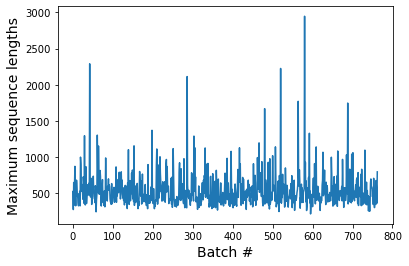

In [11]:
max_seqlens = []
batches = 0


for batch in analysis_ds:
    max_seqlens.append(
        int(tf.cast(tf.math.reduce_max(batch["summary_tokens_len"]), dtype=tf.int32,))
    )
    batches += 1

plt.plot(np.arange(batches), max_seqlens)
plt.xlabel("Batch #", fontsize=14)
plt.ylabel("Maximum sequence lengths", fontsize=14)
plt.show()